In [1]:
import aplpy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import astropy.table as Table
from astropy.io import ascii
from scipy.interpolate import interp1d

In [2]:
def losVel(func, lam, apCen):
    return (func(apCen)-lam)/func(apCen) * 3e5

In [13]:
def addPeak(apCent,peak,figname,offset,right=False,col='r',fontcol='w'):
    if right:
        sign=1
        align='left'
    elif not right:
        sign=-1
        align='right'

    figname.add_label(peak+3*sign,apCent+offset,r'$\lambda = %s \AA$'%peak,horizontalalignment=align,color=fontcol)
    return

In [36]:
def subpltFITS(fig,name,centerCoord,offset,galData,conData,kind,maxP,w,h,sub=1):
    filepath = 'SN_Images/%s/%s_01_B.fits'%(name,name)
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center']),1)
    if sub == 1:
        subCoords = [0.05,0.05,0.425,0.9]
        titleType = 'Gaussian'
        f = interp1d(galData['Aperture Center'],galData['Peak (Gaussian)'],kind=kind)
        fArr = np.vstack((f(apSpace),apSpace+offset))
        conLam = 'Peak (Gaussian)'
    elif sub == 2:
        subCoords = [0.55,0.05,0.425,0.9]
        titleType = 'Maximum'
        f = interp1d(galData['Aperture Center'],galData['Peak (Maximum)'],kind=kind)
        fArr = np.vstack((f(apSpace),apSpace+offset))
        conLam = 'Peak (Maximum)'
    
    subplt = aplpy.FITSFigure(filepath,figure=fig,subplot=subCoords)
    subplt.recenter(centerCoord[0],centerCoord[1],width=w,height=h)
    subplt.show_grayscale(stretch='power',pmax=maxP)
    subplt.set_title('%s - %s - %.2f km/s Offset'%(name,titleType,losVel(f,conData[conLam],conData['Aperture Center'])))
    subplt.axis_labels.set_xtext(r'Peak H$\alpha$ Wavelength ($\AA$)')
    subplt.axis_labels.set_ytext('Aperture Center (pix)')
    
    subplt.show_markers(fArr[0,:],fArr[1,:],marker='.',edgecolor='orange')
    
    for line in galData:
        addPeak(line['Aperture Center'],line[conLam],subplt,offset)
    
    addPeak(conData['Aperture Center'],conData[conLam],subplt,offset,col='k',fontcol='k')
    
    subplt.show_markers(galData[conLam],galData['Adjusted Aperture'],marker='o',s=50,edgecolor=None,facecolor='r')
    subplt.show_markers(conData[conLam],conData['Adjusted Aperture'],marker='*',s=150,edgecolor=None,facecolor='r')
    
    return



def pltFITS(name,centerCoord,offset,maxP=99,w=25,h=160):
    dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center'] + offset
    
    galData = dataTable[:-1]
    conData = dataTable[-1]
    
    if len(galData) > 3:
        kind = 'cubic'
    else:
        kind = 'quadratic'
    
#     apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center']),1)
#     fg = interp1d(galData['Aperture Center'],galData['Peak (Gaussian)'],kind=kind)
#     fm = interp1d(galData['Aperture Center'],galData['Peak (Maximum)'],kind=kind)
#     gArr = np.vstack((fg(apSpace),apSpace+offset))
#     mArr = np.vstack((fm(apSpace),apSpace+offset))
    
#     filepath = 'SN_Images/%s/%s_01_B.fits'%(name,name)
    
    fig = plt.figure(figsize=(15,9))
    
    subpltFITS(fig,name,centerCoord,offset,galData,conData,kind,maxP,w,h,sub=1)
    subpltFITS(fig,name,centerCoord,offset,galData,conData,kind,maxP,w,h,sub=2)
    
    fig.savefig('SN_Images/%s/%s.png'%(name,name))
    fig.show()
    return

In [49]:
def pltInterp(name,offset):
    dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center'] + offset
    
    galData = dataTable[:-1]
    conData = dataTable[-1]
    
    if len(galData) > 3:
        kind = 'cubic'
    else:
        kind = 'quadratic'
    
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center'])+1,1)
    fg = interp1d(galData['Aperture Center'],galData['Peak (Gaussian)'],kind=kind)
    fgArr = np.vstack((fg(apSpace),apSpace+offset))
    fm = interp1d(galData['Aperture Center'],galData['Peak (Maximum)'],kind=kind)
    fmArr = np.vstack((fm(apSpace),apSpace+offset))
    
    fig = plt.figure(figsize=(15,7))
    
    fig.add_subplot(1,2,1)
    plt.title('%s - Gaussian - %.2f km/s Offset'%(name,losVel(fg,conData['Peak (Gaussian)'],conData['Aperture Center'])))
    plt.ylabel('Aperture Center (px)')
    plt.xlabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Gaussian)'],galData['Aperture Center'])
    plt.plot(fg(apSpace),apSpace,'--',label='Interpolation')
    plt.scatter(conData['Peak (Gaussian)'],conData['Aperture Center'],label=name)
    plt.scatter(fg(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
    plt.plot(np.linspace(float(min(conData['Peak (Gaussian)'],fg(conData['Aperture Center']))),
                float(max(conData['Peak (Gaussian)'],fg(conData['Aperture Center']))),50),
                [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
    fig.add_subplot(1,2,2)
    plt.title('%s - Maximum - %.2f km/s Offset'%(name,losVel(fm,conData['Peak (Maximum)'],conData['Aperture Center'])))
    plt.xlabel('Aperture Center (px)')
    plt.ylabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Maximum)'],galData['Aperture Center'])
    plt.plot(fm(apSpace),apSpace,'--',label='Interpolation')
    plt.scatter(conData['Peak (Maximum)'],conData['Aperture Center'],label=name)
    plt.scatter(fm(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
    plt.plot(np.linspace(float(min(conData['Peak (Maximum)'],fm(conData['Aperture Center']))),
                float(max(conData['Peak (Maximum)'],fm(conData['Aperture Center']))),50),
                [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('SN_Images/%s/%s_interp.png'%(name,name))

In [50]:
def pltAll(name,centerCoord,offset,maxP=99,w=10,h=160):
    pltFITS(name,centerCoord,offset,maxP=maxP,w=w,h=h)
    pltInterp(name,offset)

INFO: Auto-setting vmin to -9.287e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.643e+01 [aplpy.core]


INFO: Auto-setting vmin to -8.362e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.096e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


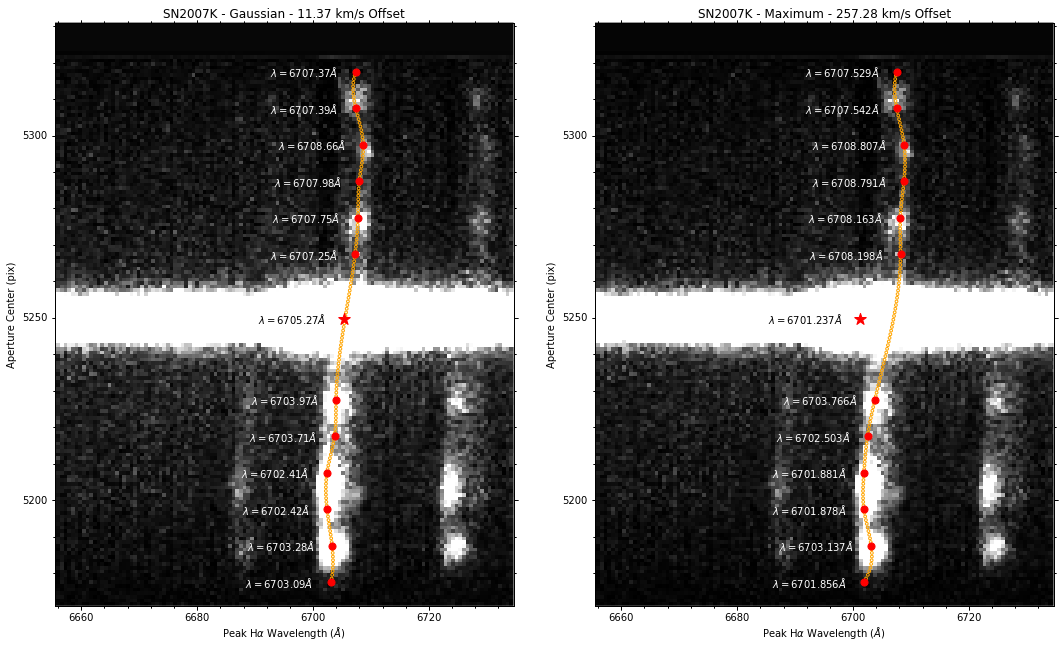

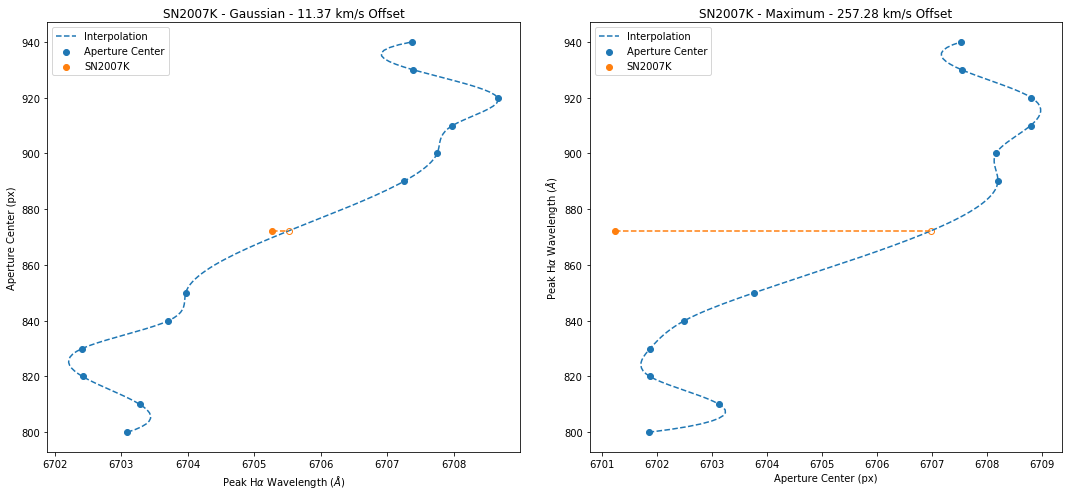

In [51]:
pltAll("SN2007K",(6695,5251),5177.5-800)

INFO: Auto-setting vmin to -1.530e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.910e+01 [aplpy.core]


INFO: Auto-setting vmin to -1.715e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.696e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


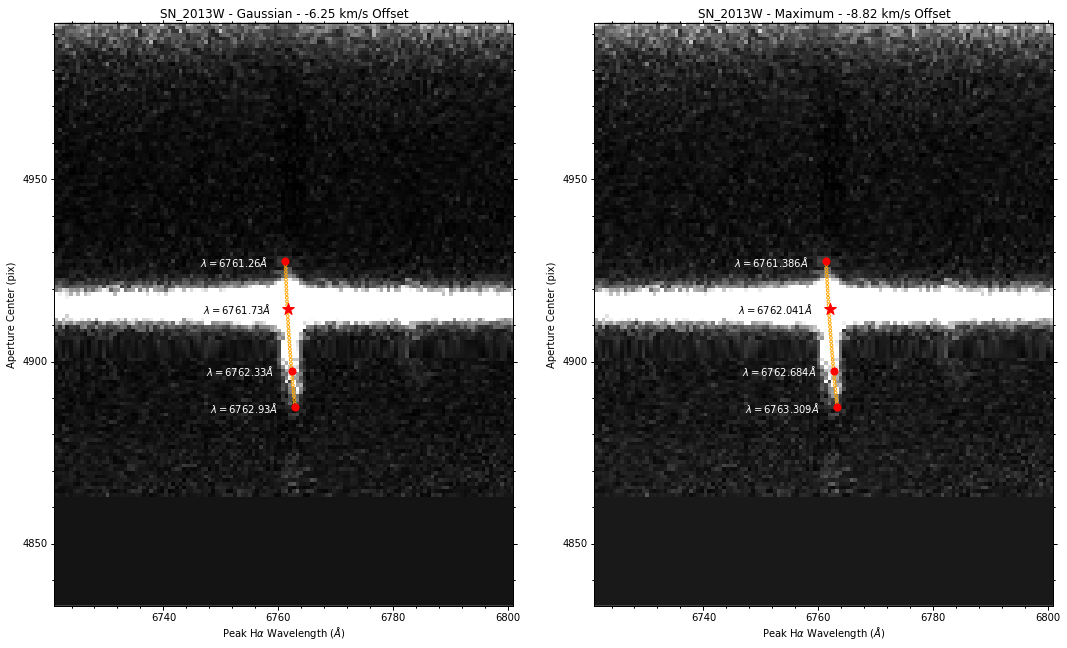

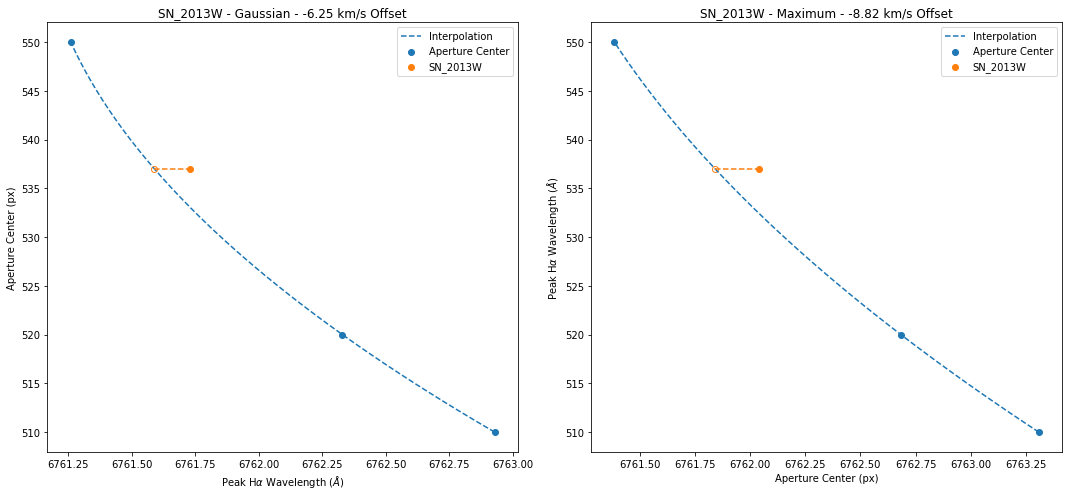

In [52]:
pltAll("SN_2013W",(6761,4913),4877.8-500.3)